In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer


In [25]:
# Load the dataset
data = pd.read_csv('C:\\Users\\Sahiti\\OneDrive\\Desktop\\income\\heart.csv')  # Replace with your dataset file path

# Separate features and target
X = data.drop('target', axis=1)
y = data['target']

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [26]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': xgb.XGBClassifier()
}

# Compare models using validation set
results = {}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    val_accuracy = model.score(X_val_scaled, y_val)
    results[model_name] = val_accuracy

In [27]:
# Print validation set results
for model_name, accuracy in results.items():
    print(f"{model_name}: Validation Accuracy = {accuracy*100:.2f}%")

Logistic Regression: Validation Accuracy = 81.82%
Random Forest: Validation Accuracy = 97.40%
SVM: Validation Accuracy = 88.31%
Naive Bayes: Validation Accuracy = 78.57%
XGBoost: Validation Accuracy = 98.70%


In [28]:
# Train and evaluate the best model on the test set
best_model_name = max(results, key=lambda k: np.mean(results[k]))
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)
test_accuracy = best_model.score(X_test_scaled, y_test)
print(f"Best Model ({best_model_name}) Test Accuracy: {test_accuracy*100:.2f}%")

Best Model (XGBoost) Test Accuracy: 99.35%


In [29]:
# Compare models using cross-validation
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall: {recall*100:.2f}%")
    print(f"F1-score: {f1*100:.2f}%")
    print("Confusion Matrix:")
    print(cm)
    print("-" * 50)

Model: Logistic Regression
Accuracy: 79.22%
Precision: 79.57%
Recall: 85.06%
F1-score: 82.22%
Confusion Matrix:
[[48 19]
 [13 74]]
--------------------------------------------------
Model: Random Forest
Accuracy: 98.70%
Precision: 100.00%
Recall: 97.70%
F1-score: 98.84%
Confusion Matrix:
[[67  0]
 [ 2 85]]
--------------------------------------------------
Model: SVM
Accuracy: 89.61%
Precision: 89.89%
Recall: 91.95%
F1-score: 90.91%
Confusion Matrix:
[[58  9]
 [ 7 80]]
--------------------------------------------------
Model: Naive Bayes
Accuracy: 84.42%
Precision: 83.87%
Recall: 89.66%
F1-score: 86.67%
Confusion Matrix:
[[52 15]
 [ 9 78]]
--------------------------------------------------
Model: XGBoost
Accuracy: 99.35%
Precision: 100.00%
Recall: 98.85%
F1-score: 99.42%
Confusion Matrix:
[[67  0]
 [ 1 86]]
--------------------------------------------------


In [30]:
# Initialize dictionaries to store metrics
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Compare models and calculate metrics
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    accuracy_scores[model_name] = accuracy_score(y_test, y_pred)
    precision_scores[model_name] = precision_score(y_test, y_pred)
    recall_scores[model_name] = recall_score(y_test, y_pred)
    f1_scores[model_name] = f1_score(y_test, y_pred)


In [31]:
# Create dataframes for visualization
accuracy_df = pd.DataFrame(list(accuracy_scores.items()), columns=['Model', 'Accuracy'])
precision_df = pd.DataFrame(list(precision_scores.items()), columns=['Model', 'Precision'])
recall_df = pd.DataFrame(list(recall_scores.items()), columns=['Model', 'Recall'])
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Model', 'F1-Score'])

# Combine dataframes
metrics_df = accuracy_df.merge(precision_df, on='Model').merge(recall_df, on='Model').merge(f1_df, on='Model')


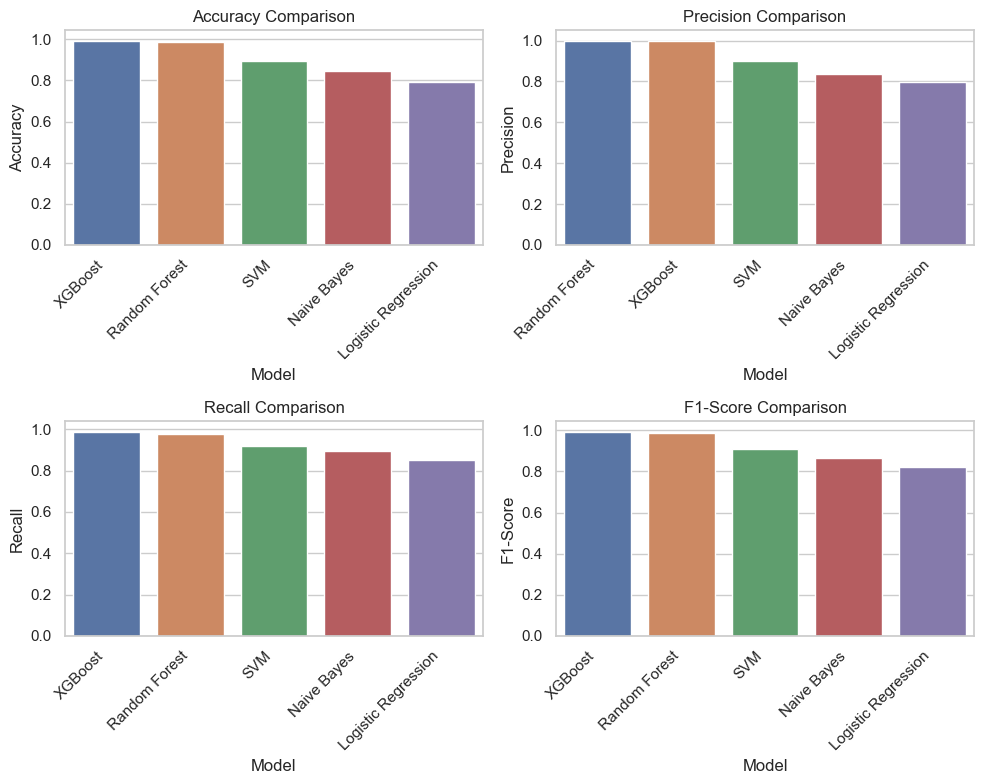

In [32]:
# Create visualizations
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Accuracy comparison
plt.subplot(221)
sns.barplot(x='Model', y='Accuracy', data=metrics_df.sort_values(by='Accuracy', ascending=False))
plt.title('Accuracy Comparison')
plt.xticks(rotation=45, ha='right')

# Precision comparison
plt.subplot(222)
sns.barplot(x='Model', y='Precision', data=metrics_df.sort_values(by='Precision', ascending=False))
plt.title('Precision Comparison')
plt.xticks(rotation=45, ha='right')

# Recall comparison
plt.subplot(223)
sns.barplot(x='Model', y='Recall', data=metrics_df.sort_values(by='Recall', ascending=False))
plt.title('Recall Comparison')
plt.xticks(rotation=45, ha='right')

# F1-Score comparison
plt.subplot(224)
sns.barplot(x='Model', y='F1-Score', data=metrics_df.sort_values(by='F1-Score', ascending=False))
plt.title('F1-Score Comparison')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

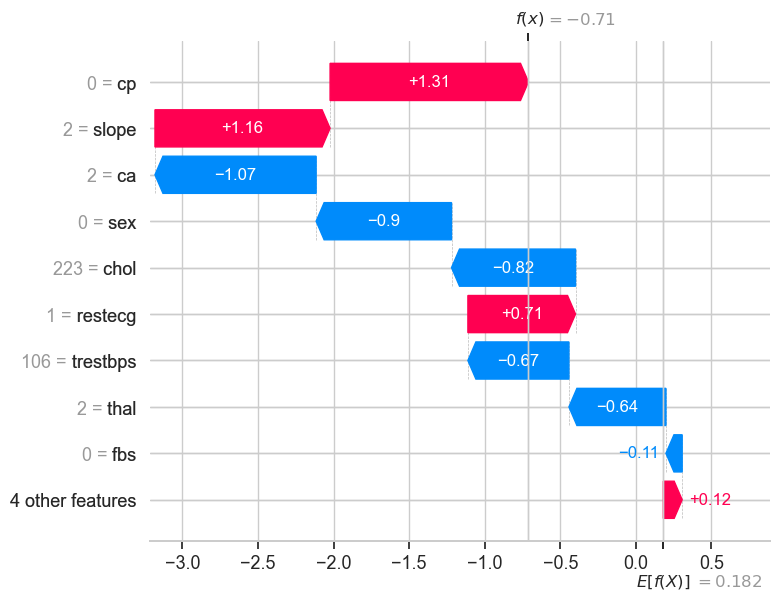

In [33]:
# Initialize the SHAP explainer
explainer = shap.Explainer(best_model)

# Explain predictions for the test set
shap_values = explainer(X)

# Visualize an explanation for a specific instance (e.g., the first instance in the test set)
shap.plots.waterfall(shap_values[21])

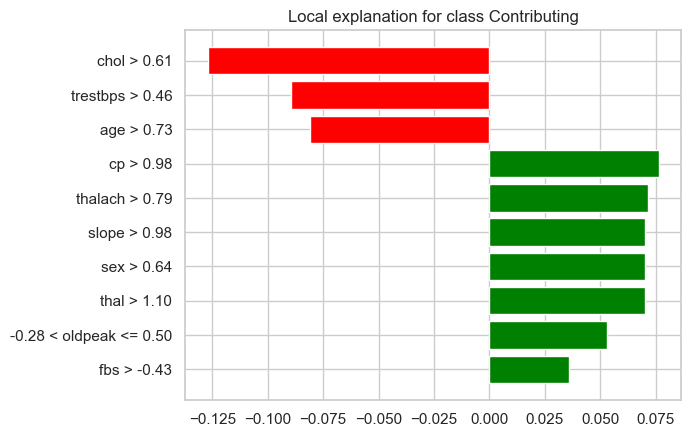

In [34]:
# Initialize the LIME explainer
explainer = LimeTabularExplainer(X_train_scaled, feature_names=X.columns, class_names=['Non-Contributing', 'Contributing'], mode='classification')

# Explain predictions for the test set
instance_to_explain = X.iloc[19] # +2th record
explanation = explainer.explain_instance(instance_to_explain, model.predict_proba)

# Set the background color of the explanation plot to white
explanation.as_pyplot_figure().set_facecolor('white')

# Display the explanation
explanation.show_in_notebook(show_all='False')

In [36]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train model
best_model.fit(X_train_scaled, y_train)

# Get input from the user for each feature
input_data = []
for feature_name in X.columns:
    value = float(input(f"Enter value for {feature_name}: "))
    input_data.append(value)

# Convert the input data into a numpy array
input_array = np.array(input_data).reshape(1, -1)

# Get predicted probabilities for the input data
predicted_probabilities = best_model.predict_proba(input_array)

# Print the predicted probabilities for each class
class_names = ['No heart disease', 'Heart disease']
for class_name, probabilities in zip(class_names, predicted_probabilities):
    other_class = 1 - probabilities[0]
    print(f"{class_name}: {probabilities[0]*100:.1f}%")
    print(f"{class_names[1]}: {other_class*100:.1f}%")

No heart disease: 99.6%
Heart disease: 0.4%


In [ ]:
# Separate features and target
X = data.drop('target', axis=1)
y = data['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

# Compare models using cross-validation
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    results[model_name] = scores

# Print cross-validation results
for model_name, scores in results.items():
    print(f"{model_name}: Mean accuracy = {np.mean(scores)*100:.2f}%, Standard deviation = {np.std(scores):.2f}")

# Train and evaluate the best model on the test set
best_model_name = max(results, key=lambda k: np.mean(results[k]))
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)
test_accuracy = best_model.score(X_test_scaled, y_test)
print(f"Best Model ({best_model_name}) Test Accuracy: {test_accuracy*100:.2f}%")


Logistic Regression: Mean accuracy = 84.88%, Standard deviation = 0.03
Random Forest: Mean accuracy = 97.93%, Standard deviation = 0.02
SVM: Mean accuracy = 91.95%, Standard deviation = 0.02
Best Model (Random Forest) Test Accuracy: 98.54%
